# Adaptive PDE discretizations on Cartesian grids, Taichi implementations

## Volume : Proximal methods

## Part : Ballistic Benamou-Brenier formulations

## Chapter : Anisotropic Quadratic Porous Medium Equation

$
\newcommand\diver{\mathrm{div}}
\DeclareMathOperator\prox{prox}
\DeclareMathOperator\argmin{argmin}
\newcommand\bT{\mathbb{T}}
\newcommand\Id{\mathrm{Id}}
\newcommand\bZ{\mathbb{Z}}
$

This notebook is devoted to the discretization of the anisotropic *quadratic porous medium equation* (QPME), using the *ballistic Benamou-Brenier* (BBB) formulation. It is related with the work : 

* Erwan Stämpfli, Jean-Marie Mirebeau. Discretization and convergence of the ballistic Benamou-Brenier formulation of the porous medium and Burgers’ equations. Preprint, 2025


The PDE of interest reads
\begin{align*}
    \partial_t u &= \frac 1 2 \diver(D \nabla u^2) + f,&
    u(0) &= u_0,
\end{align*}
on the periodic domain $\bT^d$ (for simplicity), and the time interval $[0,T]$. We denote by $D$ a smooth field of positive definite matrices, and by $f$ a given r.h.s.


**Ballistic Benamou-Brenier (BBB) formulation.**
Following the (BBB) approach, we consider the optimization problem
\begin{align*}
    \inf_{\phi(T)=0} \int_{[0,T] \times \bT^d} \frac{(\partial_t \phi)^2}{1-\diver(D \nabla \phi)} + F \phi,
\end{align*}
where $F(t,x) = -u_0(x)+\int_0^t f(s,x) ds$.

This optimization problem is obtained considering the minimization $\int u^2$ among all weak solutions of the QPME, and taking the Fenchel-Rockafellar dual optimization problem.
It can be reformulated as follows (omitting the r.h.s.)
\begin{align*}
    &\inf_{\rho(T)=1} \int_{[0,T] \times \bT^d} \frac{m^2}{\rho},&
    &\partial_t \rho + \diver(D \nabla m) = 0,
\end{align*}
using the change of variables 
\begin{align*}
    m &:= \partial_t \phi,&
    \rho &:= 1-\diver(D \nabla \phi).
\end{align*}
We use a proximal primal-dual optimization method to solve this reformulation.

**Projection onto the discretized continuity equation $\partial_t \rho + \diver(D \nabla m) = 0$.** 
The field $D$ of symmetric positive definite matrices is decomposed in the form
$$
    D = \sum_{e \in E} \lambda^e e e^\top, 
$$
where $E \subset \bZ^d$ is a finite set of vectors with integer coordinates, and $(\lambda^e)_{e \in E}$ are smooth coefficients over the domain. 

We introduce additional variables $(m_e)_{e \in E}$ and $(\mu_e)_{e \in E}$, and consider the orthogonal projections onto the sets of constraints:
$$
    \partial_\tau \rho + \sum_{e \in E} \partial_h^{+e} m^e = 0,
$$
and
$$
    m^e = \lambda^e \mu^e, \ \forall e \in E,
$$
and
$$
    -\partial_h^{-e} m = \mu^e, \ \forall e \in E.
$$
The first and last projections are computed in the Fourier domain, and the middle one in usual coordinates.

## 0. Importing the required libraries

In [1]:
# Please use "pip install agd, agdt" on Google Colab, etc
# Unless you have manually downloaded the libraries, in which you can set the directories here
agd_path = "/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations"; agdt_path = "/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AGDT/AdaptiveGridDiscretizations_Taichi"
import sys; sys.path.insert(0,agd_path); sys.path.insert(0,agdt_path)

In [2]:
# Imports from the AGD library
from agd import AutomaticDifferentiation as ad
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
norm = ad.Optimization.norm
norminf = ad.Optimization.norm_infinity
from agd.Plotting import savefig,Tissot
def mixednorm(arr,p,q): return norm(norm(arr,q,axis=1,averaged=True),p,averaged=True)
from agd import Selling,Metrics
from agd.ExportedCode.Notebooks_Algo import TensorSelling as ts

# Imports from the AGDT library
from agdt.Proximal import Proj,QPME,Prox,Misc
from agdt.Proximal.Misc import convert_dtype,tifunc

# Import from standard Python libraries
import taichi as ti
import numpy as np
import scipy
from matplotlib import pyplot as plt
import copy
from scipy.sparse.linalg import lsqr as sparse_lsqr

cmul = ti.math.cmul; cconj = ti.math.cconj
π = np.pi
np.set_printoptions(linewidth=2000)

[Taichi] version 1.7.2, llvm 15.0.7, commit 0131dce9, osx, python 3.11.11


[I 03/25/25 14:37:20.764 4419011] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


### 0.1 Additional configuration

In [3]:
ti.init(arch=ti.cpu,default_fp=ti.f64) # Default data types are f32 et i32

[Taichi] Starting on arch=arm64


At some point, we use pytorch to compute some fast Fourier transforms on the GPU. The computational device must be specified here.

In [4]:
device = 'mps'; # Appropriate for Apple M1
#device = 'cuda'; # Appropriate for Nvidia graphics cards

In [14]:
#savefig.dirName = "/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/Papers/BBBPorous/Burgers/Illustrations/QPME"

## 1. Validation of orthogonal projections

The proximal optimization method used in this notebooks requires the computation of orthogonal projections onto various linear subspaces. 
The agdt.QPME file provides suitable implementations, using the Taichi library and some fast Fourier transforms. 

In this preliminary section, we check their validity, by comparing them with LSQR implementations.

In [15]:
def QPME_cstr_Iso(m,ρ,dt,dx):
    """The residues of the linear constraints Dtρ + Δm = 0 and  m(t) = -m(2T-t)"""
    e = np.eye(ρ.ndim).astype(int)
    et = e[:,0]; ex = e[:,1:] # Time axis is the first one, space axes are the other ones
    Dtρ = fd.DiffUpwind(ρ,et,dt,padding=None) # *Periodic* time boundary conditions
    Dxxm = fd.Diff2(m,ex,dx,padding=None) # Periodic space boundary conditions
    Δm = Dxxm.sum(axis=0)
    nT = len(m)//2
    return dt*(Dtρ+Δm), m[:nT]+m[nT:][::-1] # dt introduced for normalization
    
def QPME_cstr_λ(m,μ,λ): 
    """Residue of the linear constraint m = λμ"""
    return m-λ*μ
    
def QPME_cstr_E0(me,ρ,E,dt,dx):
    """Residue of the linear constraints me(t)=-me(-t) and Dtρ + sum(De me, e in E) = 0"""
    nT=len(me)//2
    et = np.zeros(ρ.ndim,dtype=int); et[0]=1
    return me[:nT]+me[nT:][::-1], fd.DiffUpwind(ρ,et,dt,padding=None) \
    + sum([fd.DiffUpwind(me[...,i],(0,*e),dx,padding=None) for i,e in enumerate(E)])
    
def QPME_cstr_E1(μe,m,E,dx):
    """Residue of the linear constraints μe(t)=-μe(-t) and μe = -D[-e] m"""
    nT=len(μe)//2
    return μe[:nT]+μe[nT:][::-1],*[μe[...,i] + fd.DiffUpwind(m,(0,*-e),dx,padding=None) for i,e in enumerate(E)]

def maxres_cstr(arrs): 
    """Shows the largest residue of all constraints"""
    return np.array(tuple(map(norminf,arrs)))

In [17]:
# Projection onto the constraint m = λ μ
dt=0.7; dx=0.6; shape = (6,7)
np.random.seed(42)
m,μ = [np.random.rand(*shape)-0.5 for i in range(2)]
λ = np.random.rand(*shape[1:])

proj_ti = QPME.mk_proj_λ(λ) # Numerically efficient ad-hoc implementation using Taichi
proj_lsqr = Proj.make_lsqr_proj(QPME_cstr_λ,(m,μ),Aargs=(λ,)) # Inefficient implementation
m_ti,μ_ti = proj_ti(m.copy(),μ.copy())
m_lsqr,μ_lsqr = proj_lsqr(m,μ)
assert np.allclose(m_ti,m_lsqr,atol=1e-6)
assert np.allclose(μ_ti,μ_lsqr)

# Projection onto the other linear constraints, in one space dimension
dt=0.7; dx=0.6; shape = (6,7)
E = np.array([[1],[-2]]) # One dimensional
np.random.seed(42)
m,ρ = [np.random.rand(*shape)-0.5 for i in range(2)]
me,μe = [np.random.rand(*shape,len(E))-0.5 for i in range(2)]

proj_ti = QPME.mk_proj_E(dt,dx,E,ρ) # Numerically efficient ad-hoc implementation using Taichi
proj_lsqr0 = Proj.make_lsqr_proj(QPME_cstr_E0,(me,ρ),Aargs=(E,dt,dx)) # Inefficient implementation
proj_lsqr1 = Proj.make_lsqr_proj(QPME_cstr_E1,(μe,m),Aargs=(E,dx)) # Inefficient implementation

m_ti,ρ_ti,me_ti,μe_ti = proj_ti(m,ρ,me,μe)
me_lsqr,ρ_lsqr = proj_lsqr0(me,ρ)
μe_lsqr,m_lsqr = proj_lsqr1(μe,m)

print(f"{maxres_cstr(QPME_cstr_E0(me_lsqr,ρ_lsqr,E,dt,dx))}, {maxres_cstr(QPME_cstr_E1(μe_lsqr,m_lsqr,E,dx))}")
print(f"{maxres_cstr(QPME_cstr_E0(me_ti,ρ_ti,E,dt,dx))}, {maxres_cstr(QPME_cstr_E1(μe_ti,m_ti,E,dx))}")
for x_lsqr,x_ti in zip((m_lsqr,ρ_lsqr,me_lsqr,μe_lsqr), (m_ti,ρ_ti,me_ti,μe_ti)):
    assert np.allclose(x_lsqr,x_ti)
print("One dimension validated")

# Projection onto the other linear constraints, in two space dimensions
dt=0.7; dx=0.6; shape = (6,7,8)
E = np.array([[1,0],[1,1],[0,1],[-1,1]]) # Two dimensional
np.random.seed(42)
m,ρ = [np.random.rand(*shape)-0.5 for i in range(2)]
me,μe = [np.random.rand(*shape,len(E))-0.5 for i in range(2)]

proj_ti = QPME.mk_proj_E(dt,dx,E,ρ)
proj_lsqr0 = Proj.make_lsqr_proj(QPME_cstr_E0,(me,ρ),Aargs=(E,dt,dx))
proj_lsqr1 = Proj.make_lsqr_proj(QPME_cstr_E1,(μe,m),Aargs=(E,dx))

m_ti,ρ_ti,me_ti,μe_ti = proj_ti(m,ρ,me,μe)
me_lsqr,ρ_lsqr = proj_lsqr0(me,ρ)
μe_lsqr,m_lsqr = proj_lsqr1(μe,m)

for x_lsqr,x_ti in zip((m_lsqr,ρ_lsqr,me_lsqr,μe_lsqr), (m_ti,ρ_ti,me_ti,μe_ti)):
    assert np.allclose(x_lsqr,x_ti)
print("Two dimensions validated")

[5.55111512e-17 1.11022302e-16], [2.77555756e-17 5.55111512e-17 5.55111512e-17]
[1.38777878e-16 4.16333634e-16], [5.55111512e-17 5.55111512e-17 5.55111512e-17]
One dimension validated
Two dimensions validated


## 2. Constant tensor field $D$

We first implement the Chambolle-Pock (CP) primal-dual optimization method, for solving the BBB formulations of the isotropic ($D=Id$) and anisotropic variants of the QPME.

In [18]:
def CP_Iso(u0,dt,dx,nT,τ_f=1,verb=0,niter=1000,rhs=None):
    """
    Chambolle-Pock optimization method applied to the BBB formulation of the isotropic QPME, Dtu = (1/2)Δu^2
    """
    # Normalization of the initial condition
    xp = Misc.get_array_module(u0)
    if xp is not np: u0_xp=u0; u0=u0.cpu().numpy() # Some cheap preprocessing done on the CPU ...
    np_float_t = Misc.convert_dtype['np'][u0.dtype]
    Nu0 = np.sqrt(np.sum(u0**2)/np_float_t(u0.size)) # Averaged L2 norm of u0
    u0 = u0/Nu0
    dt = dt*Nu0
    
    # Initialization
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m = np.asarray([*(u0,)*nT,*(-u0,)*nT])
    if rhs is None: rhs = np.zeros_like(ρ[:nT+1])
    Rhs = Prox.mk_rhs(dt,u0,rhs)
    if xp is not np: ρ,m,Rhs = [Misc.asarray(e,like=u0_xp) for e in (ρ,m,Rhs)]
    
    x = Misc.asobjarray(m,ρ) # x contains the pair of variables ρ,m
    y = 0*x # Dual variable
    tx = copy.deepcopy(x)
    dt,dx,τ_f = map(np_float_t,(dt,dx,τ_f))
    
    # Note : prox_f,proj_g, are inplace operators by default (modifiy input)
    prox_f = Misc.useobjarray(QPME.mk_prox_Iso(dt,dx,Rhs))
    proj_g = Misc.useobjarray(QPME.mk_proj_Iso(dt,dx,ρ)) # projection operator
    def prox_gs(y,τ=1): return y-proj_g(y,inplace=False) # Projection onto orthogonal space
    τ_gs = 1/τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity

    x,y,tx = Misc.ChambollePock_raw(x,y,tx,prox_f,prox_gs,τ_f,τ_gs,niter)
    return x[0]*Nu0,x[1] # Put back the normalization

In [9]:
def CP_Aniso(u0,dt,dx,nT,λ,E,τ_f=1,verb=0,niter=1000,rhs=None):
    """
    Chambolle-Pock optimization method applied to the BBB formulation of the aniisotropic QPME, Dtu = (1/2) div(D grad u^2)
    Same as CP_Iso, but with offsets E and corresponding coefficients λ
    """
    # Normalization of the initial condition
    xp = Misc.get_array_module(u0)
    if xp is not np: u0_xp=u0; u0=u0.cpu().numpy() # Only for some cheap preprocessing...
    np_float_t = Misc.convert_dtype['np'][u0.dtype]
    Nu0 = np.sqrt(np.sum(u0**2)/np_float_t(u0.size)) # Averaged L2 norm of u0
    u0 = u0/Nu0
    dt = dt*Nu0

    # Initialization
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m = np.asarray([*(u0,)*nT,*(-u0,)*nT])
    if rhs is None: rhs = np.zeros_like(ρ[:nT+1])
    Rhs = Prox.mk_rhs(dt,u0,rhs)
    Ne = len(E)
    me = np.zeros_like(u0,shape=ρ.shape+(Ne,))
    μe = me.copy()
    if xp is not np: ρ,m,Rhs,me,μe = [Misc.asarray(e,like=u0_xp) for e in (ρ,m,Rhs,me,μe)]

    x = Misc.asobjarray(m,ρ,me,μe)
    y = 0*x; tx = copy.deepcopy(x) # Dual variable, additional variable
    dt,dx,τ_f = map(np_float_t,(dt,dx,τ_f))

    # Note : prox_f and proj_g are inplace operators by default (modifiy input)
    prox_f_obj = QPME.mk_prox_Iso(dt,dx,Rhs)
    proj_f_λ = QPME.mk_proj_λ(λ)
    @Misc.useobjarray
    def prox_f(m,ρ,me,μe,τ,inplace=True):
        return *prox_f_obj(m,ρ,τ,inplace),*proj_f_λ(me,μe,inplace)

    proj_g = Misc.useobjarray(QPME.mk_proj_E(dt,dx,E,ρ))        
    def prox_gs(y,τ=1): return y-proj_g(y,inplace=False) # Projection onto orthogonal space
    τ_gs = 1/τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity
    x,y,tx = Misc.ChambollePock_raw(x,y,tx,prox_f,prox_gs,τ_f,τ_gs,niter)
    return x[0]*Nu0,x[1],x[2]*Nu0,x[3]*Nu0  # Put back the normalization

### 2.1 One dimensional

We illustrate numerical solutions of the one-dimensional isotropic QPME.

In [20]:
#nX = 1024; nT = 20
nX = 256; nT = 50
#nX = 5; nT=2
aX,dx = np.linspace(-0.5,0.5,nX,retstep=True,endpoint=False)
aX+=dx/2
X = aX[None]

Ti = 1e-4; Tf = 2e-3; T = Tf-Ti; u0 = QPME.Barenblatt(Ti,X)
dt = T/nT

In [23]:
%%time
m_Iso,ρ_Iso = CP_Iso(u0,dt,dx,nT,τ_f=1,niter=2000) #5000

CPU times: user 6.38 s, sys: 839 ms, total: 7.22 s
Wall time: 3.44 s


The numerical solution is close to the known exact profile, namely the Barenblatt self-similar solution.
(Which is compactly supported and non-differentiable on the support boundary.)

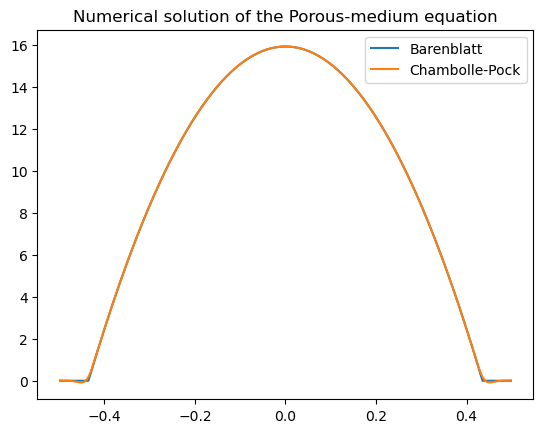

In [24]:
u_Iso = QPME.u_from_mρ(m_Iso,ρ_Iso)
iT = nT-1 #nT-1 # Choose from 0 (initial condition) to  nT-1 (final time)
t = Ti+dt*(iT+0.5)
plt.title("Numerical solution of the Porous-medium equation")
plt.plot(aX,QPME.Barenblatt(Ti+dt*(iT+0.5), X),label="Barenblatt")
plt.plot(aX,u_Iso[iT],label="Chambolle-Pock")
plt.legend();

The exact form of the auxiliary optimization variables $\rho$ and $m$ is also known. In particular, $\rho$ is not self-similar, and features $4$ discontinuities.

The numerical approximation of $\rho$ is not very accurate near the discontinuities, but this is not a significant problem since these oscillations are outside of the support of $u = m/\rho$. 

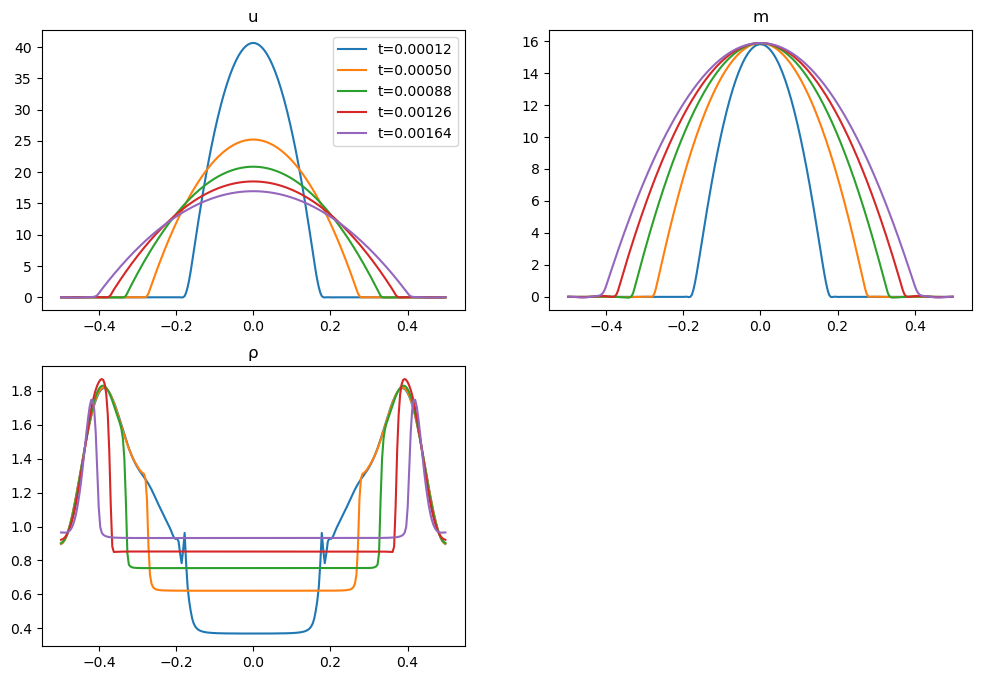

In [25]:
iT = nT-1
fig=plt.figure(figsize=[12,8])
for i,(var,name,aname) in enumerate(((u_Iso,"u","u"),(m_Iso,"m","m"),(ρ_Iso,"ρ","rho"))):
    ax = plt.subplot(2,2,1+i)
    plt.title(name)
    for j in range(0,iT,10):
        plt.plot(aX,var[j],label=f"t={Ti+(j+0.5)*dt:.5f}")
    if aname=="u": plt.legend()
    savefig(fig,aname,ax=ax)

We have implemented another discretization of the BBB formulation, which is in principle devoted to varying matrix fields $D$, but can also be applied to $D=\Id$. In that case, both implementations solve exactly the same discrete optimization problem.

The generality of this implementation comes at a cost: 
- Each iterations of the Chambolle-Pock method is more expensive, both in terms of time and of memory usage.
- The convergence of the Chambolle-Pock method is slower (less accurate result for the same number of iterations).
In particular, the Chambolle-Pock solution is not very accurate near the non-differentiabilities of the Barenblatt profile, unless a very large number of iterations is used, e.g. 10000.

In [33]:
%%time
E = np.array([[1]]); λ = np.ones_like(u0,shape=u0.shape+(len(E),))  #,[-1]
m_Aniso,ρ_Aniso,me_Aniso,μe_Aniso = CP_Aniso(u0,dt,dx,nT,λ,E,τ_f=1,niter=2000) # Use 10000 for more accurate result (slow)

CPU times: user 50.4 s, sys: 8.33 s, total: 58.7 s
Wall time: 33.5 s


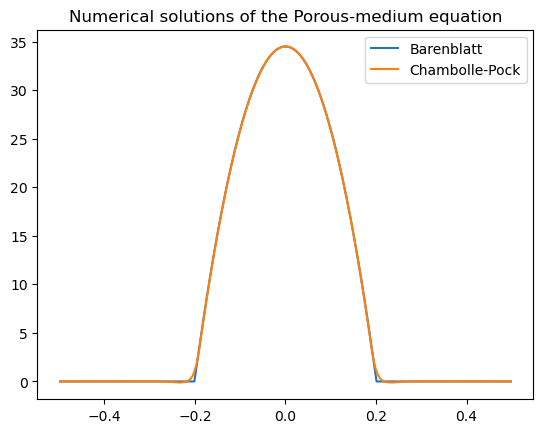

In [34]:
u_Aniso = QPME.u_from_mρ(m_Aniso,ρ_Aniso)
iT = 2 # Choose from 0 (initial condition) to  nT-1 (final time)
t = Ti+dt*(iT+0.5)
plt.title("Numerical solutions of the Porous-medium equation")
plt.plot(aX,QPME.Barenblatt(Ti+dt*(iT+0.5), X),label="Barenblatt")
plt.plot(aX,u_Aniso[iT],label="Chambolle-Pock")
plt.legend();

In [35]:
print(np.array([norminf(x) for x in QPME_cstr_E0(me_Aniso,ρ_Aniso,E,dt,dx)]))
print(np.array([norminf(x) for x in QPME_cstr_E1(μe_Aniso,m_Aniso,E,dx)]))
print(norminf(QPME_cstr_λ(me_Aniso,μe_Aniso,λ)))

[8.52651283e-14 2.18854925e-02]
[8.52651283e-14 8.90433807e-03]
2.0194839173657902e-28


In [36]:
[norminf(x) for x in QPME_cstr_Iso(m_Iso,ρ_Iso,dt,dx)]

[np.float64(0.00028133607669866617), np.float64(4.811519803193942e-05)]

#### 2.1.1 Illustrating the dependency w.r.t the number of iterations

We investigate the numerical error w.r.t the exact solution (Barenblatt profile) as a function of the number of iterations of the Chambolle-Pock optimization method. 

In [46]:
%%time
#nX = 1024; nT = 20
nX = 128; nT = 10
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = aX[None]

Ti = 1e-4; Tf = 1e-3; T = Tf-Ti; u0 = QPME.Barenblatt(Ti,X-0.5)
dt = T/nT

ue = np.array([QPME.Barenblatt(Ti+(it+0.5)*dt,X-0.5) for it in range(nT)])

niters = np.geomspace(20,400,7).astype(int)
uhs = []
err_iso = []
u_iso = []
u_aniso = []
for niter in niters:
    m,ρ = CP_Iso(u0,dt,dx,nT,τ_f=1,niter=niter)
    uh = QPME.u_from_mρ(m,ρ)
    u_iso.append(uh)
    err = uh-ue
    err[~np.isfinite(err)]=0 # Fix for the first iterations...
    err_iso.append( [mixednorm(err,np.inf,1), norm(err,1,averaged=True), norm(err,2,averaged=True), norm(err,np.inf,averaged=True)])

err_iso = np.array(err_iso)

CPU times: user 775 ms, sys: 220 ms, total: 995 ms
Wall time: 747 ms


In [47]:
err_iso,niters

(array([[ 4.76068149,  2.08628789,  2.91241775, 13.45445655],
        [ 2.48202041,  1.28667258,  1.62072115,  6.09482007],
        [ 0.69346773,  0.56651738,  0.71770975,  2.00840996],
        [ 0.2784679 ,  0.23254537,  0.30613155,  2.1244265 ],
        [ 0.18376075,  0.0947518 ,  0.18116256,  2.19110527],
        [ 0.16509316,  0.06044924,  0.15660427,  2.18652097],
        [ 0.1629484 ,  0.05508371,  0.15262193,  2.18604948]]),
 array([ 20,  32,  54,  89, 147, 242, 400]))

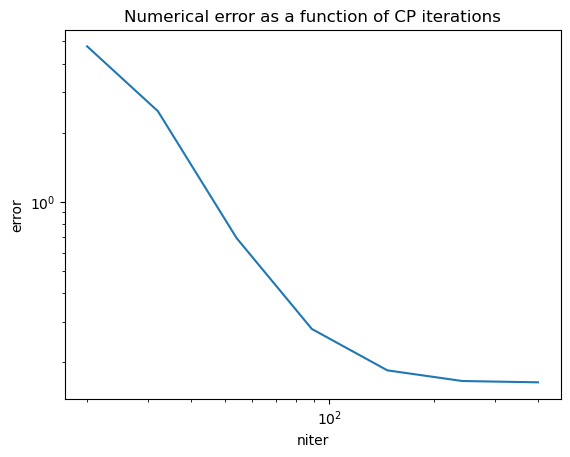

In [63]:
plt.title("Numerical error as a function of CP iterations")
plt.loglog(niters,err_iso[:,0])
plt.xlabel("niter")
plt.ylabel("error");

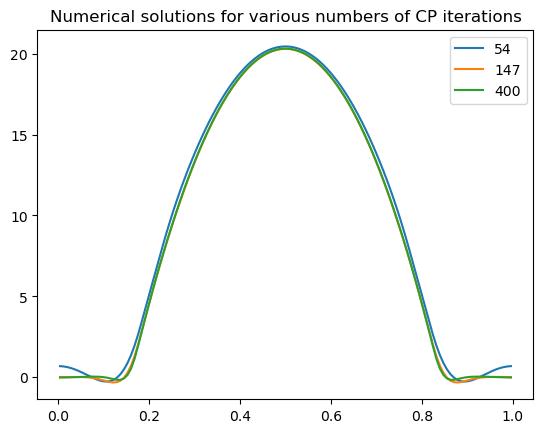

In [62]:
plt.title("Numerical solutions for various numbers of CP iterations")
for i in (2,4,6):
    plt.plot(*X,u_iso[i][-1],label=f"{niters[i]}")
plt.legend();

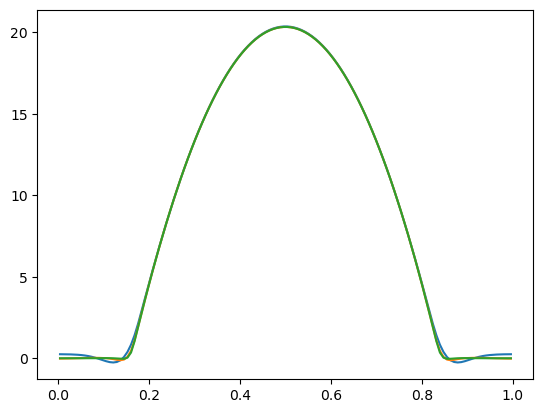

In [67]:
plt.plot(*X,u_iso[5][-1])
plt.plot(*X,u_iso[10][-1])
plt.plot(*X,u_iso[-1][-1])

#### 2.1.2 Large time convergence to the Barenblatt profile

The Barenblatt profile is an attractor: if we start from a compactly supported solution in time, then we eventually converge (up to a suitable rescaling) to the Barenblatt profile.
The following experiment illustrates this phenomenon.

In [64]:
#nX = 1024; nT = 20
nX = 128; nT = 10
#nX = 5; nT=2
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = aX[None]

Ti = 0; Tf = 1; T = Tf-Ti
#u0 = QPME.Barenblatt(Ti,X-0.5)
u0 = np.zeros(nX)
mid = nX//2
u0[mid]=1; u0[mid+4]=0.7; u0[mid-1]=0.3
dt = T/nT

In [65]:
%%time
m_Iso,ρ_Iso = CP_Iso(u0,dt,dx,nT,τ_f=1,niter=2000)

CPU times: user 1.15 s, sys: 293 ms, total: 1.44 s
Wall time: 1.1 s


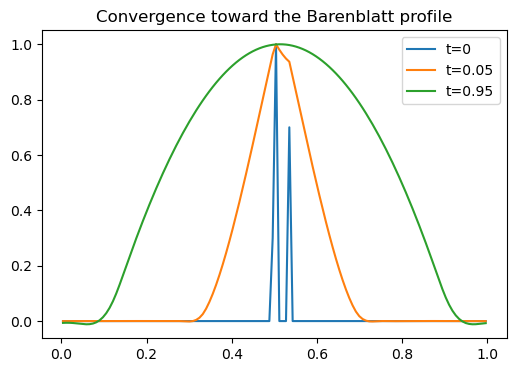

In [66]:
u_Iso = QPME.u_from_mρ(m_Iso,ρ_Iso)
fig=plt.figure(figsize=[6,4])
plt.title("Convergence toward the Barenblatt profile")
#plt.plot(aX,QPME.Barenblatt(Ti+dt*(iT+0.5), X-0.5),label="Barenblatt")
plt.plot(aX,u0,label="t=0")
iT=0; plt.plot(aX,u_Iso[iT] / np.max(u_Iso[iT]),label=f"t={Ti+dt*(iT+0.5):.2f}")
iT=nT-1; plt.plot(aX,u_Iso[iT]/ np.max(u_Iso[iT]),label=f"t={Ti+dt*(iT+0.5):.2f}")
plt.legend();
savefig(fig,"BarenblattConv.png")

Note that numerical solutions are normalized (divided by their maximum value).

### 2.2 Two dimensional experiments

We reproduce the Barenblatt profile, in two dimensions, using both the isotropic-only scheme and the general anisotropic scheme in the case $D=\Id$. 

In [68]:
nX = 35; nT = 6
#nX = 50; nT = 10 # bit longish
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

Ti = 2e-5
u0 = QPME.Barenblatt(Ti,X-0.5)
Tf = 2e-4; T = Tf-Ti
dt = T/nT

In [69]:
%%time
m_Iso,ρ_Iso = CP_Iso(u0,dt,dx,nT,τ_f=1,niter=1000)

CPU times: user 2.15 s, sys: 384 ms, total: 2.54 s
Wall time: 1.36 s


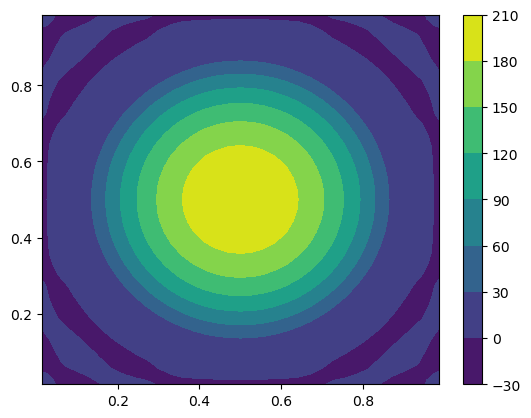

In [71]:
u_Iso = QPME.u_from_mρ(m_Iso,ρ_Iso)
iT = 2 # Choose from 0 (initial condition) to  nT-1 (final time)
plt.contourf(*X,u_Iso[iT])
plt.colorbar();

In [72]:
%%time
E = np.array([[1,0],[0,1]]); λ = np.ones_like(u0,shape=u0.shape+(len(E),))  #,[-1]
m_Aniso,ρ_Aniso,me_Aniso,μe_Aniso = CP_Aniso(u0,dt,dx,nT,λ,E,τ_f=1,niter=1000) #10000 cv is so slow where non-smooth

CPU times: user 4.55 s, sys: 773 ms, total: 5.32 s
Wall time: 3.35 s


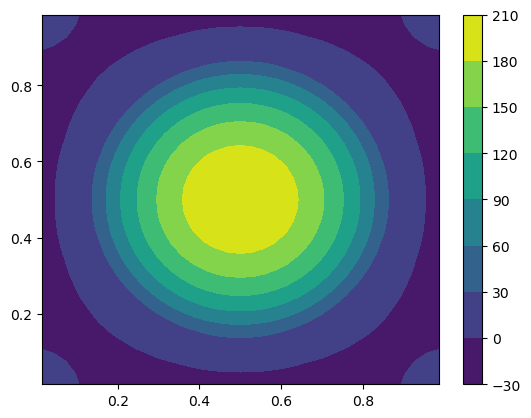

In [73]:
u_Aniso = QPME.u_from_mρ(m_Aniso,ρ_Aniso)
iT = 2 # Choose from 0 (initial condition) to  nT-1 (final time)
plt.contourf(*X,u_Aniso[iT])
plt.colorbar();

### 2.3 Two dimensional anisotropic

We compute a linearly distorted Barenblatt profile, by solving the QPME with a *constant* tensor field $D \neq \Id$.

In [74]:
κ = 2 # Anisotropy ratio
#θ = np.pi/6
θ=0
D = Metrics.Riemann.from_diagonal((κ,1/κ)).rotate_by(θ).m # det(D)=1
λ,E = Selling.Decomposition(D)
A = scipy.linalg.fractional_matrix_power(D,-1/2)

nX = 35; nT = 6
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
Ti = 2e-5
Tf = 1e-4; T = Tf-Ti
dt = T/nT

Y = lp.dot_AV(A[:,:,None,None],X-0.5) # Transformed coordinates
u0 = QPME.Barenblatt(Ti,Y)

In [75]:
%%time
λ_ = λ*np.ones_like(u0)[...,None]; E_ = E.T
m_Aniso,ρ_Aniso,me_Aniso,μe_Aniso = CP_Aniso(u0,dt,dx,nT,λ_,E_,τ_f=1,niter=1000) #10000 cv is so slow where non-smooth

CPU times: user 5.54 s, sys: 828 ms, total: 6.37 s
Wall time: 4.1 s


For $\theta = 0$, and niter=1000, the figure is not perfectly symmetric w.r.t the $x$-axis especially the boudary of the levelset associated with the $0$ value. This is due to the slow convergence of the proximal solver; the exact minimizer of the discrete problem is actually symmetric.

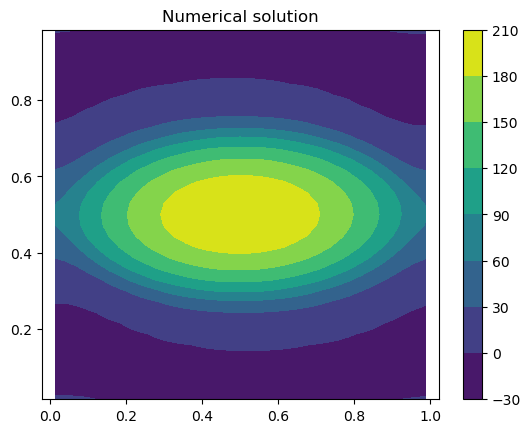

In [77]:
plt.title("Numerical solution")
u_Aniso = QPME.u_from_mρ(m_Aniso,ρ_Aniso)
iT = nT-1 # Choose from 0 (initial condition) to  nT-1 (final time)
plt.contourf(*X,u_Aniso[iT])
plt.colorbar(); plt.axis('equal');

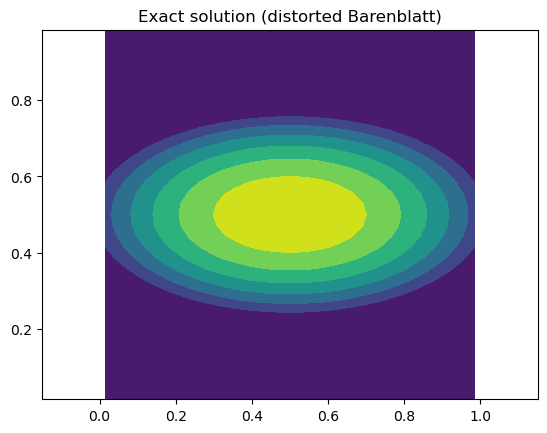

In [78]:
plt.title("Exact solution (distorted Barenblatt)")
t = Ti+dt*(iT+0.5)
plt.contourf(*X,QPME.Barenblatt(t,Y)); plt.axis('equal');

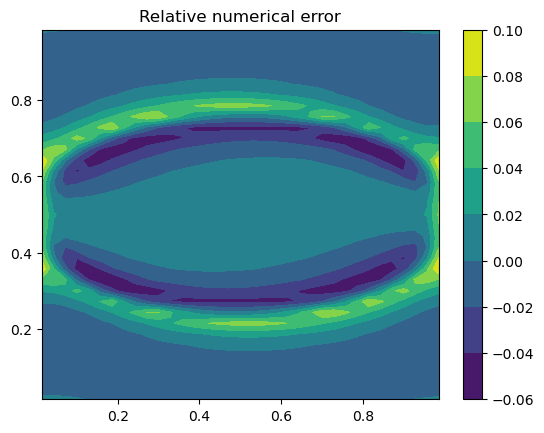

In [85]:
plt.title("Relative numerical error")
plt.contourf(*X, (u_Aniso[iT] - QPME.Barenblatt(t,Y))/np.max(u_Aniso[iT]) )
plt.colorbar();

## 3. Right hand side

We consider a right hand side (r.h.s), so as to test the code in different settings.

In [87]:
def CP_Iso2(u0,dt,dx,nT,τ_f=1,verb=0,niter=1000,rhs=None):
    # Normalization of the initial condition
    xp = Misc.get_array_module(u0)
    if xp is not np: u0_xp=u0; u0=u0.cpu().numpy() # Only for some cheap preprocessing...
    np_float_t = Misc.convert_dtype['np'][u0.dtype]
    Nu0 = np.sqrt(np.sum(u0**2)/np_float_t(u0.size)) # Averaged L2 norm of u0
    Nu0=1
    u0 = u0/Nu0
    dt = dt*Nu0
    
    # Initialization
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m = np.asarray([*(u0,)*nT,*(-u0,)*nT])
    if rhs is None: rhs = np.zeros_like(ρ[:nT+1])
    Rhs = mk_rhs2(dt,u0,rhs)
    if xp is not np: ρ,m,Rhs = [Misc.asarray(e,like=u0_xp) for e in (ρ,m,Rhs)]
    
    x = Misc.asobjarray(m,ρ) # x contains the pair of variables ρ,m
    y = 0*x # Dual variable
    tx = copy.deepcopy(x)
    dt,dx,τ_f = map(np_float_t,(dt,dx,τ_f))
    
    # Note : prox_f,proj_g, are inplace operators by default (modifiy input)
    prox_f = Misc.useobjarray(QPME.mk_prox_Iso(dt,dx,Rhs))
    proj_g = Misc.useobjarray(QPME.mk_proj_Iso(dt,dx,ρ)) # projection operator
    def prox_gs(y,τ=1): return y-proj_g(y,inplace=False) # Projection onto orthogonal space
    τ_gs = 1/τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity
    x,y,tx = Misc.ChambollePock_raw(x,y,tx,prox_f,prox_gs,τ_f,τ_gs,niter)
    return x[0]*Nu0,x[1] # Put back the normalization

### 3.1 One dimensional constant metric, with r.h.s

Let us acknowledge that the accuracy is not very good in the last timestep(s). 

This is likely due to the terminal boundary condition $\rho(T)=1$, which is artificial and induces a boundary layer.

In [88]:
def uexact(t,x):
    return 1.5+np.sin(2*np.pi*(x[0]-t))

def rhs_Iso(u,T,X):
    """Computes Dtu-Δ(u^2/2), using automatic differentiation."""
    X_ad = ad.Dense2.identity(constant=X,shape_free=(len(X),))
    T_ad = ad.Dense.identity(constant=T,shape_free=tuple())
    Dtu = u(T_ad,X).gradient(0)
    Δu2 = lp.trace((u(T,X_ad)**2).hessian())
    return -(Dtu - 0.5*Δu2)

def mk_rhs2(dt,u0,f):
    nT = f.shape[0]
    F = np.cumsum(f,axis=0)
    for t in range(nT): F[t] -= f[t]/2 
    F = u0 - F*dt
    F = np.concatenate((F,-F[::-1]),axis=0)
    return np.ascontiguousarray(F)

In [89]:
%%time
T,dt = np.linspace(0,0.5,20,retstep=True)
aX,dx = np.linspace(0,1,35,endpoint=False,retstep=True)
aX+=dx/2
X = aX[None]
nT = len(T)-1

u0 = uexact(0,X)
Tp = T[:-1]+dt/2
rhs = rhs_Iso(uexact,Tp[:,None],X); m_Iso,ρ_Iso = CP_Iso2(u0,dt,dx,nT,niter=1000,rhs=rhs)
#rhs = rhs_Iso(uexact,T[:,None],X); m_Iso,ρ_Iso = CP_Iso(u0,dt,dx,nT,niter=1000,rhs=rhs)

CPU times: user 510 ms, sys: 247 ms, total: 756 ms
Wall time: 531 ms


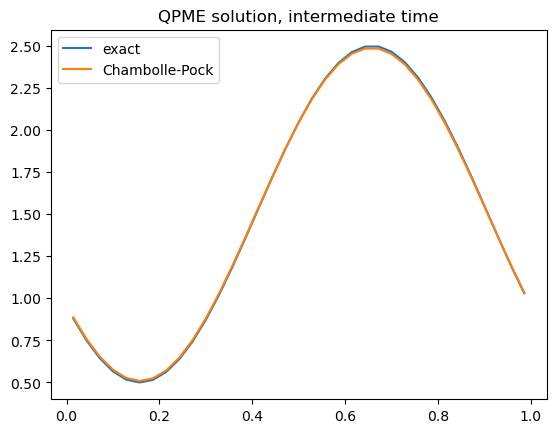

In [94]:
u_Iso = QPME.u_from_mρ(m_Iso,ρ_Iso)
iT = nT-4 # Choose from 0 (initial condition) to  nT-1 (final time)
t = Ti+dt*(iT+0.5)
plt.title("QPME solution, intermediate time")
plt.plot(aX,uexact(t, X),label="exact")
plt.plot(aX,u_Iso[iT],label="Chambolle-Pock")
plt.legend();

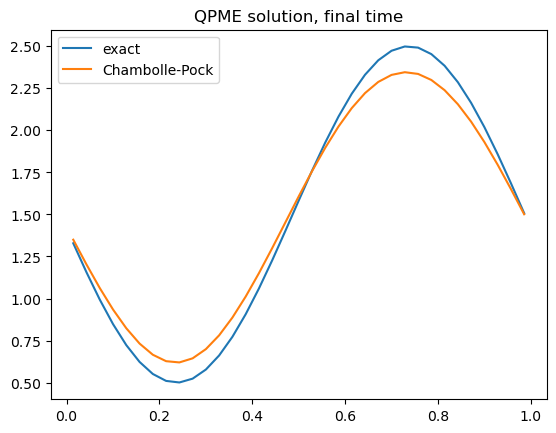

In [95]:
u_Iso = QPME.u_from_mρ(m_Iso,ρ_Iso)
iT = nT-1 # Choose from 0 (initial condition) to  nT-1 (final time)
t = Ti+dt*(iT+0.5)
plt.title("QPME solution, final time")
plt.plot(aX,uexact(t, X),label="exact")
plt.plot(aX,u_Iso[iT],label="Chambolle-Pock")
plt.legend();

The numerical solution obtained with the Newton method appears to be identical, hence the issue is not with the Chambolle-Pock implementation.

In [96]:
def Dt_Δ(ϕ,dx,dt):
    """
    Returns approximations of dϕ/dt and Δϕ, computed using upwind and centered finite differences respectively.
    The approximations are second order consistent with the values of these functions at time 
    (k+0.5)dt and k dt respectively, where k is the time step index.
    """
    e = np.eye(ϕ.ndim).astype(int)
    et = e[:,0]; ex = e[:,1:] # Time axis is the first one, space axes are the other ones
    Dtϕ = fd.DiffUpwind(ϕ,et,dt,padding=0) # Null boundary condition at the final time
    Dxxϕ = fd.Diff2(ϕ,ex,dx,padding=None) # Periodic space boundary conditions
    Δϕ = Dxxϕ.sum(axis=0)
    return Dtϕ,Δϕ
    

def iΔ_from_Δ(Δϕ,Δϕpos=0.5):
    """
    Returns an approximation of 1/(1-Δϕ), and max(Δϕ).
    The approximation is second order consistent with the value at (k + Δϕpos)*dt,
    where k is the time step index. If Δϕpos = 0.5, then this matches with the time derivative.
    """    
    Δmax = np.max(ad.remove_ad(Δϕ)[:-1],initial=0) if Δϕpos==1 else np.max(ad.remove_ad(Δϕ))
    iΔϕ0 = 1/(1-Δϕ)
    barrier = np.log(iΔϕ0)
    iΔϕ1 = np.roll(iΔϕ0,-1,axis=0).copy()
    iΔϕ1[-1] = 1
    iΔϕ = iΔϕ0*(1-Δϕpos)+iΔϕ1*Δϕpos
    return iΔϕ,Δmax,barrier

def u_from_ϕ(ϕ,dx,dt):
    """Expresses the solution u of the porous diffusion, in terms of ϕ of the optimization"""
    Dtϕ,Δϕ = Dt_Δ(ϕ,dx,dt)
    iΔϕ,_,_ = iΔ_from_Δ(Δϕ)
    return Dtϕ * iΔϕ

def Energy_ϕ(ϕ,u0,rhs,dx,dt,Δpos=0.5,ϵlog=1e-6):
    """Energy of the variational formulation of the quadratic porous medium equation, in the variable ϕ"""
    ϕ = ϕ.reshape((-1,*u0.shape))
    Dtϕ,Δϕ = Dt_Δ(ϕ,dx,dt)
    iΔϕ, Δmax, barrier = iΔ_from_Δ(Δϕ,Δpos)
    if Δmax>=1: return np.inf # 
    
    interior = Dtϕ**2 * iΔϕ / 2 + ϵlog*barrier
    boundary = u0*ϕ[0]
    ϕ1 = np.roll(ϕ,-1,axis=0).copy(); ϕ1[-1]=0
    interior2 = rhs*(ϕ+ϕ1)/2
    ad.simplify_ad(interior) # Optional. Sometimes speeds up the sparse matrix assembly
    return dt*np.sum(interior-interior2)+np.sum(boundary)

In [97]:
%%time
ϕ0 = np.zeros((nT,aX.size))
ϕnewt = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(u0,rhs,dx,dt),step_min=1e-8,maxiter=400).reshape(ϕ0.shape)
unewt = u_from_ϕ(ϕnewt,dx,dt)

Initialization, objective 0.0
Iteration 1, Newton step 0.00390625, objective -3.661085707192156.
Iteration 2, Newton step 0.0001220703125, objective -3.7821095172558428.
Iteration 3, Newton step 0.0001220703125, objective -3.8984429217664354.
Iteration 4, Newton step 0.0001220703125, objective -4.009354782226618.
Iteration 5, Newton step 0.0001220703125, objective -4.116011641912533.
Iteration 6, Newton step 0.0001220703125, objective -4.219392595298194.
Iteration 8, Newton step 0.000244140625, objective -4.517254120600101.
Iteration 10, Newton step 0.000244140625, objective -4.8963407639657195.
Iteration 12, Newton step 0.00048828125, objective -5.619351168245665.
Iteration 14, Newton step 0.000244140625, objective -5.978261721232507.
Iteration 16, Newton step 0.0001220703125, objective -6.419587964641126.
Iteration 20, Newton step 0.00048828125, objective -7.527023750916999.


/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:46: RuntimeWarning: invalid value encountered in log
  def log(x):	y=1./x; return (np.log(x),y,-y**2)
/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_90179/1506291113.py:23: RuntimeWarning: invalid value encountered in log
  barrier = np.log(iΔϕ0)


Iteration 24, Newton step 0.0009765625, objective -8.668285372793472.
Iteration 28, Newton step 0.00048828125, objective -9.341195718688141.
Iteration 32, Newton step 0.00048828125, objective -9.991083114749827.
Iteration 36, Newton step 0.00048828125, objective -10.903558027046126.
Iteration 40, Newton step 0.0009765625, objective -11.581389925098307.
Iteration 44, Newton step 0.0009765625, objective -12.095552306502661.
Iteration 48, Newton step 0.0009765625, objective -12.676261960823073.
Iteration 52, Newton step 0.00048828125, objective -12.907927736013312.
Iteration 56, Newton step 0.001953125, objective -13.208863796651654.
Iteration 60, Newton step 0.001953125, objective -13.643907750564784.
Iteration 64, Newton step 0.001953125, objective -13.840838349617435.
Iteration 68, Newton step 0.001953125, objective -14.09871958379659.
Iteration 72, Newton step 0.001953125, objective -14.246906477724075.
Iteration 76, Newton step 0.00048828125, objective -14.378349948184391.
Iteration 

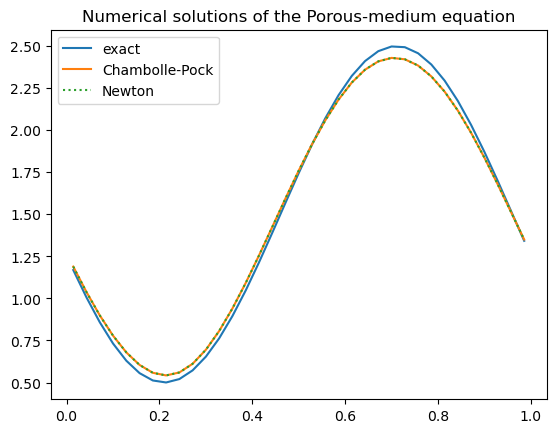

In [102]:
iT = nT-2 # Choose from 0 (initial condition) to  nT-1 (final time)
t = Ti+dt*(iT+0.5)
plt.title("Numerical solutions of the Porous-medium equation")
plt.plot(aX,uexact(t, X),label="exact")
plt.plot(aX,u_Iso[iT],label="Chambolle-Pock")
plt.plot(aX,unewt[iT],label="Newton",linestyle=":")
plt.legend();

## 4 Two dimensional anisotropic

We design a two-dimensional test case for the anisotropic QPME, with an exact solution.

In [5]:
def diffeo(X,ϵ=0.05): 
    """A measure preserving perturbation of the identity map on the torus (R/Z)^2, always invertible."""
    x,y = X
    x = x + ϵ*np.sin(2*π*y+1) 
    y = y + ϵ*np.sin(4*π*x+5) 
    x = x + ϵ*np.sin(4*π*y+3)
    y = y + ϵ*np.sin(2*π*x+2) 
    return ad.array([x,y])

def diffeo_lin(X,ϵ=0.05):
    x,y = X
    return ad.array([2*x,y])

    
def make_domain(Nx=50): 
    aX,dx = np.linspace(0,1,Nx,endpoint=False,retstep=True)
    aX+=dx/2
    X = np.array(np.meshgrid(aX,aX,indexing='ij'))
    return X,dx

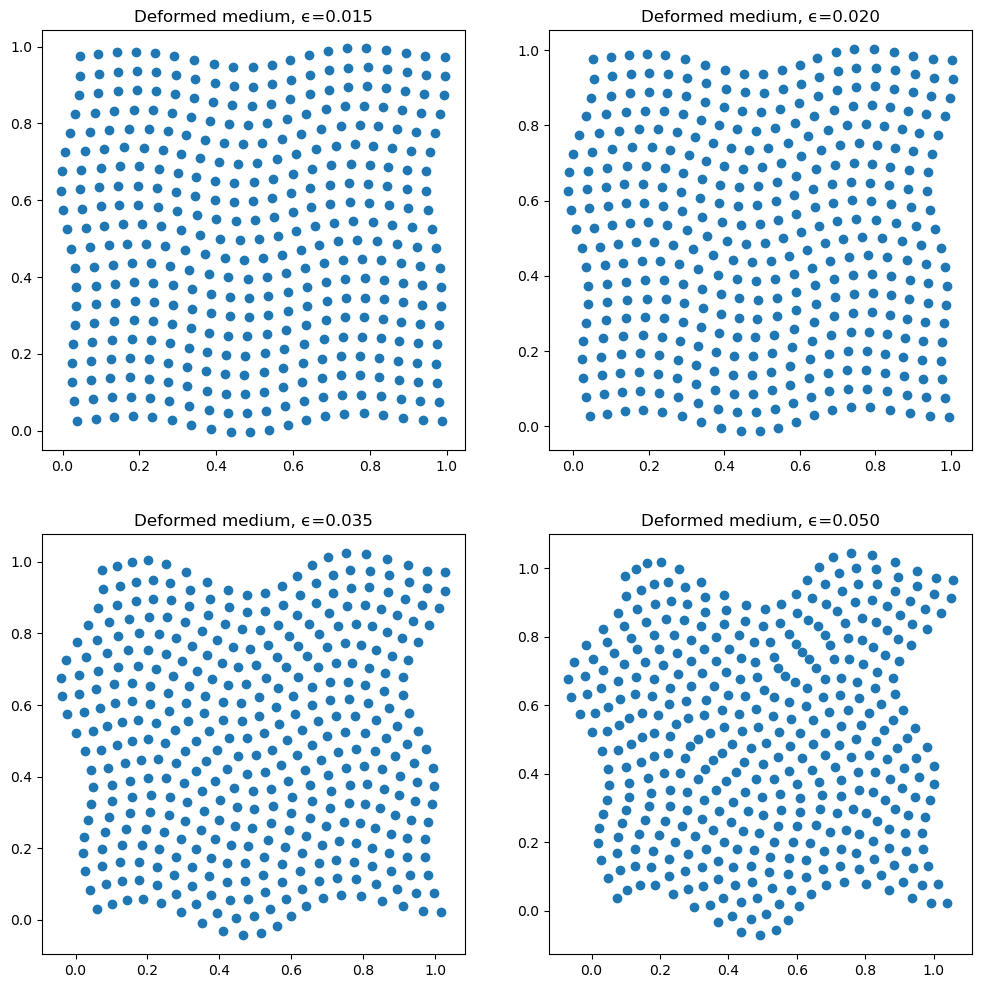

In [104]:
fig = plt.figure(figsize=[12,12])
for i,ϵ in enumerate((0.015,0.02,0.035,0.05)):
    ax = plt.subplot(2,2,1+i)
    plt.title(f"Deformed medium, {ϵ=:.3f}")
    X,dx = make_domain(20)
    plt.scatter(*diffeo(X,ϵ))
    plt.axis('equal');
    savefig(fig,f"Medium_{i}.png",ax=ax)

Max deformation ratio 1.7223 for ϵ=0.015  Largest offset : Selling 1, smooth 1
Max deformation ratio 2.0619 for ϵ=0.020  Largest offset : Selling 1, smooth 2
Max deformation ratio 3.5272 for ϵ=0.035  Largest offset : Selling 1, smooth 2
Max deformation ratio 6.0032 for ϵ=0.050  Largest offset : Selling 2, smooth 2


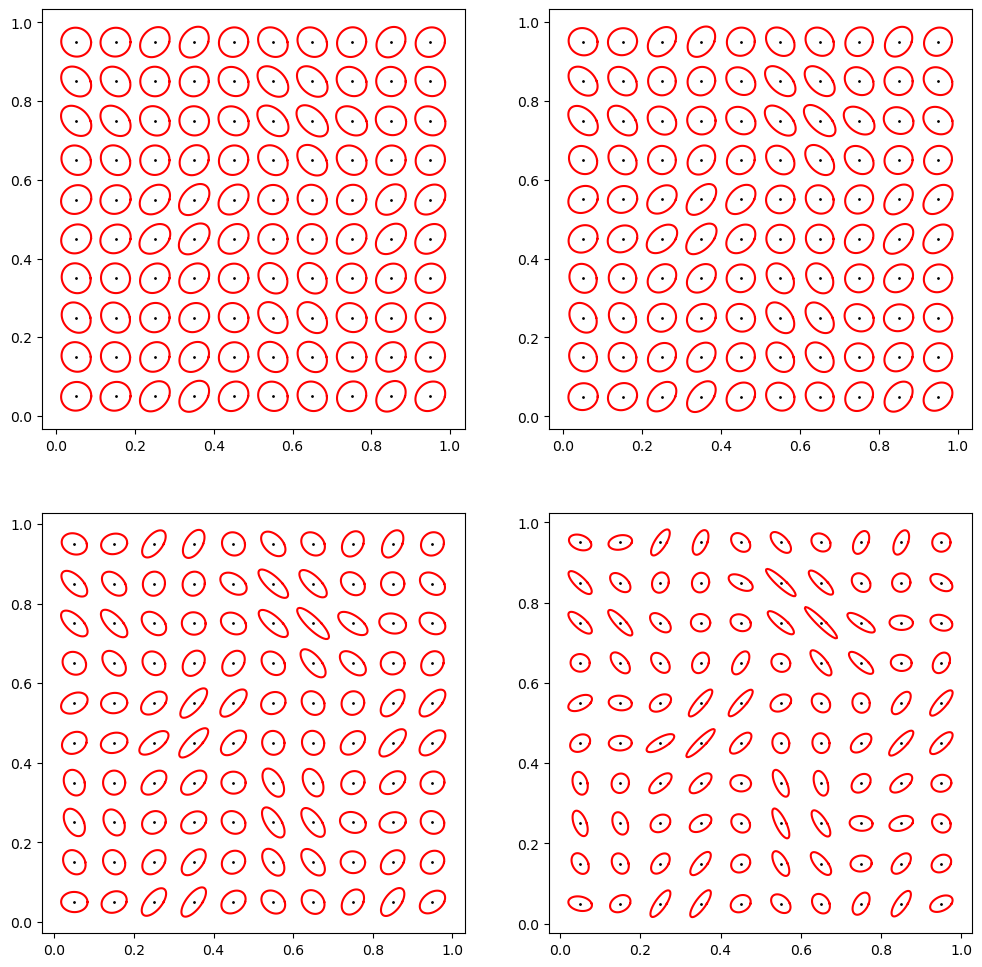

In [105]:

fig = plt.figure(figsize=[12,12])

X,dx = make_domain()
X_ad = ad.Dense.identity(constant=X,shape_free=(2,))
for i,ϵ in enumerate((0.015,0.02,0.035,0.05)):
    dϕ = diffeo(X_ad,ϵ).gradient()
    assert np.allclose(lp.det(dϕ),1)
    S = np.moveaxis(np.linalg.svd(np.moveaxis(dϕ,(0,1),(-2,-1))).S,-1,0)
    D = Metrics.Riemann(np.eye(2)).transform(dϕ).m
    _,e_sel = Selling.Decomposition(D)
    _,e_smooth = ts.smooth_decomp(D)
    print(f"Max deformation ratio {np.max(S[0]/S[1]):.4f} for {ϵ=:.3f}",
          f" Largest offset : Selling {np.max(np.abs(e_sel))}, smooth {np.max(np.abs(e_smooth))}")

    ax = plt.subplot(2,2,1+i)
    Tissot(Metrics.Riemann(D).dual(),X)
    plt.axis('equal')
    savefig(fig,f"Medium_D_{i}.png",ax=ax)

Construct a metric, taking into account the deformation.
The size of the offsets is determined by the anisotropy of the metric, and the choice of decomposition.

<!---
def int_from_offset(e):
    """
    Turns offset(s) (small vectors with integer coefficients) into integers.
    Opposite offsets are regarded as identical and yield the same integer.
    Returns : 
    - ie : corresponding integer(s)
    - r, vdim : automatically selected basis and offset dimension (needed for reconstruction)
    """
    e = np.asarray(e)
    pos = np.argmax(e!=0,axis=0) # position of the first non-zero coefficient
    e *= np.sign(np.take_along_axis(e,pos[None],0)) # Normalized offset, starts > 0
    emax = np.max(np.abs(e))
    r = 2*emax+1 # Base exponent for conversion to integer
    vdim = len(e)
    return sum(e[i] * r**(vdim-i-1) for i in range(vdim)),r,vdim

def offset_from_int(ie,r,vdim):
    """Inverse of int_from_offset"""
    e = []; emax = r//2
    for i in range(vdim): # Expand the offsets, as vectors
        mod = ie%r
        pos = mod>emax
        ie = (ie//r)+pos
        e.append(np.where(pos,mod-r,mod))
    return np.array(e[::-1])

def dense_decomp(λ,e):
    """Turns an adaptive decomposition λ,e, where the offsets e may vary from point to point,
    into a non-adaptive one, Λ,E, where E is a fixed collection of offsets"""
    ie,r,vdim = int_from_offset(e)
    Λ = ad.Sparse.spAD(np.zeros_like(λ[0]),np.moveaxis(λ,0,-1),np.moveaxis(ie,0,-1))
    Λ = np.asarray(Λ.tangent_operator().todense()) # Possible improvement : optimization opportunities here
    nz = np.any(Λ!=0,axis=0)
    Λ = Λ.T.reshape((-1,*λ.shape[1:]))
    E = offset_from_int(np.arange(len(Λ)),r,vdim)
    return Λ[nz],E[:,nz]

def conv_decomp(deconvD,conv,rtol=1e-6):
    """Apply Selling's decomposition, then convolve the coefficients, and finally prune the small ones.
    - deconvD : deconvolved positive definite matrix field. 
    - conv : convolution operator
    - rtol : relative tolerance for eliminating small coefficients.
    """
    tol = rtol * lp.trace(deconvD) # Compute absolute tolerance
    λ,e = Selling.Decomposition(deconvD) # Selling decomposition
    shape = λ[0].shape
    ie,r,vdim = int_from_offset(e)
#    vdim = len(e)
#    pos = np.argmax(e!=0,axis=0) # position of the first non-zero coefficient
#    e *= np.sign(np.take_along_axis(e,pos[None],0)) # Normalized offset, starts > 0
#    emax = np.max(np.abs(e))
#    r = 2*emax+1 # Base exponent for conversion to integer
#    ie = sum(e[i] * r**(vdim-i-1) for i in range(vdim)) # Convert offsets to integers
    Λ = ad.Sparse.spAD(np.zeros_like(λ[0]),np.moveaxis(λ,0,-1),np.moveaxis(ie,0,-1))
    Λ = Λ.tangent_operator().todense() # Possible improvement : optimization opportunities here
    Λ = np.moveaxis(np.asarray(Λ).reshape((*shape,-1)),-1,0)
    Λ = conv(Λ,depth=1)
    Λ[np.abs(Λ)<=tol]=0 # Remove almost zero coefficients
    index = fd.as_field(np.arange(len(Λ)),shape,depth=1)
    x = ad.Sparse.spAD(np.zeros_like(λ[0]),np.moveaxis(Λ,0,-1),np.moveaxis(index,0,-1))
    x.simplify_ad() # Remove null coefficients.
    λ = np.moveaxis(x.coef,-1,0) # The new coefficients
    ie = np.moveaxis(x.index,-1,0) # The new offsets, for now as integers
#    e = []
#    for i in range(vdim): # Expand the offsets, as vectors
#        mod = ie%r
#        pos = mod>emax
#        ie = (ie//r)+pos
#        e.append(np.where(pos,mod-r,mod))
#    return λ,np.array(e[::-1])
    return λ,offset_from_int(ie,r,vdim)
--->

In [106]:
diff = lambda X:diffeo(X-0.5,ϵ=0.035)
#diff = lambda X:diffeo_lin(X-0.5) 
nX = 48
X,dx = make_domain(nX) 
X_ad = ad.Dense.identity(constant=X,shape_free=(2,))
dϕ = diff(X_ad).gradient()
D = Metrics.Riemann(np.eye(2)).transform(dϕ).m
λ,e = ts.dense_decomp(*ts.smooth_decomp(D))
#λ,e = ts.dense_decomp(*Selling.Decomposition(D))
assert np.allclose(np.sum(λ*lp.outer_self(e)[...,None,None],axis=2),D)
Λ = np.array([fd.AlignedSum(λi,e[:,i],(0,1),(1/2.,1/2.),padding=None) for i,λi in enumerate(λ)])

In [107]:
e

array([[ 0,  1,  1,  1,  1,  1,  2,  2],
       [ 1, -2, -1,  0,  1,  2, -1,  1]])

In [108]:
nT = 12
Ti = 1e-5
Tf = 1e-4; T = Tf-Ti
dt = T/nT

Y = diff(X) # Transformed coordinates
u0 = QPME.Barenblatt(Ti,Y)

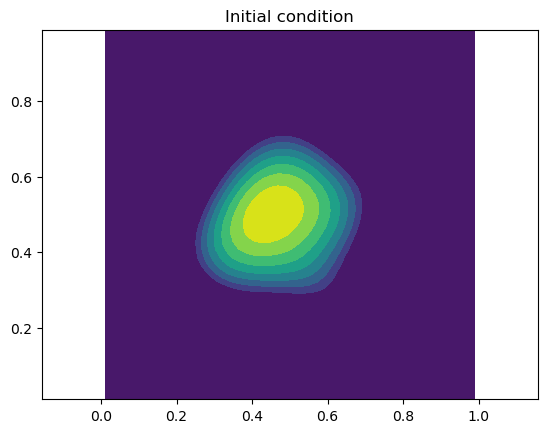

In [109]:
plt.title('Initial condition')
plt.contourf(*X,u0); plt.axis('equal');

Computation time is a bit long, because we run the code on the CPU.
See the next section for GPU acceleration.

In [110]:
%%time
λ_ = np.ascontiguousarray(np.moveaxis(Λ,0,-1))
m_Aniso,ρ_Aniso,me_Aniso,μe_Aniso = CP_Aniso(u0,dt,dx,nT,λ_,e.T,τ_f=1,niter=3000) #10000 cv is so slow where non-smooth

CPU times: user 1min 53s, sys: 17.9 s, total: 2min 11s
Wall time: 1min 36s


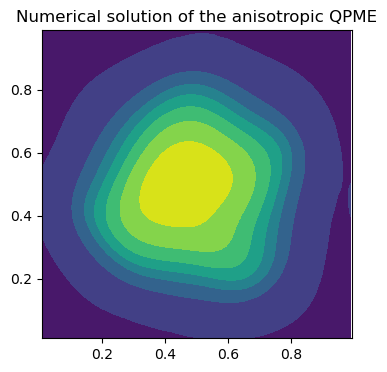

In [111]:
u_Aniso = QPME.u_from_mρ(m_Aniso,ρ_Aniso)
iT = nT-1 # Choose from 0 (initial condition) to  nT-1 (final time)
fig = plt.figure(figsize=[4,4])
plt.title("Numerical solution of the anisotropic QPME")
plt.contourf(*X,u_Aniso[iT])
#plt.colorbar(); 
plt.axis('equal')
savefig(fig,"Aniso_Num.png")

<Figure size 400x400 with 0 Axes>

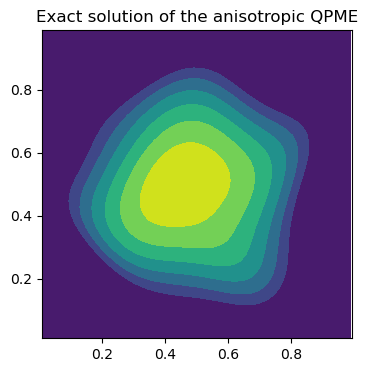

In [112]:
fig = plt.figure(figsize=[4,4])
t = Ti+dt*(iT+0.5)
uexact = QPME.Barenblatt(t,Y)
fig = plt.figure(figsize=[4,4])
plt.title("Exact solution of the anisotropic QPME")
plt.contourf(*X,uexact); plt.axis('equal');
savefig(fig,"Aniso_Exact.png");

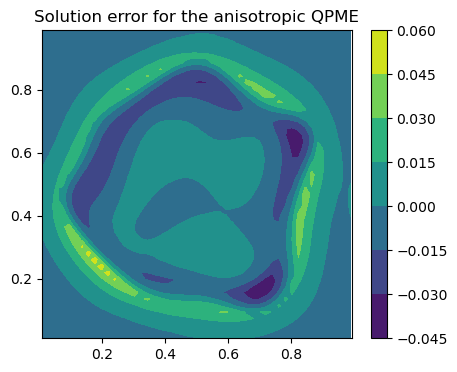

In [113]:
fig = plt.figure(figsize=[5,4])
plt.title("Solution error for the anisotropic QPME")
plt.contourf(*X,(u_Aniso[iT]-uexact)/np.max(u_Aniso))
plt.colorbar(); plt.axis('equal');
savefig(fig,"Aniso_Error.png")

### 4.1 Running on the GPU

We run the previous experiment on the GPU, thanks to Taichi's jit compilation, and pytorch's FFT.

The code has been tested on both M1 mac, and Nvidia cuda accelerators. 
On the M1 mac, the speedup is modest, if any; the point is mostly to check compatibility. 




In [6]:
nX = 256 if device=='cuda' else 50


diff = lambda X:diffeo(X-0.5,ϵ=0.035)
X,dx = make_domain(nX) 
X_ad = ad.Dense.identity(constant=X,shape_free=(2,))
dϕ = diff(X_ad).gradient()
D = Metrics.Riemann(np.eye(2)).transform(dϕ).m
#λ,e = ts.dense_decomp(*ts.smooth_decomp(D))
λ,e = ts.dense_decomp(*Selling.Decomposition(D))
assert np.allclose(np.sum(λ*lp.outer_self(e)[...,None,None],axis=2),D)
Λ = np.array([fd.AlignedSum(λi,e[:,i],(0,1),(1/2.,1/2.),padding=None) for i,λi in enumerate(λ)])
λ_ = np.ascontiguousarray(np.moveaxis(Λ,0,-1))

nT = 64
Ti = 2e-5
Tf = 1e-4; T = Tf-Ti
dt = T/nT

Y = diff(X) # Transformed coordinates
u0 = QPME.Barenblatt(Ti,Y)

In [7]:
import torch
ti.init(arch=ti.gpu,default_fp=ti.f32)
u0_gpu = torch.asarray(u0.astype(np.float32),device=device)
λ_gpu = torch.asarray(λ_.astype(np.float32),device=device)

[Taichi] Starting on arch=metal


In [10]:
%%time
m_Aniso,ρ_Aniso,me_Aniso,μe_Aniso = CP_Aniso(u0_gpu,dt,dx,nT,λ_gpu,e.T,τ_f=1,niter=50)

ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=torch.float32
ρ.dtype=to

In [155]:
ti.init(arch=ti.cpu,default_fp=ti.f32)

[Taichi] Starting on arch=arm64


In [156]:
%%time
m_Aniso,ρ_Aniso,me_Aniso,μe_Aniso = CP_Aniso(u0,dt,dx,nT,λ_,e.T,τ_f=1,niter=5)

float64 float64 float64 float64 float64 float64 <class 'numpy.float64'> <class 'numpy.float64'>
CPU times: user 998 ms, sys: 109 ms, total: 1.11 s
Wall time: 852 ms
